Epoch 01 | train=0.0136 | val=0.0134 | val RMSE=0.1157
Epoch 05 | train=0.0105 | val=0.0099 | val RMSE=0.0997
Epoch 10 | train=0.0064 | val=0.0060 | val RMSE=0.0777
Epoch 15 | train=0.0046 | val=0.0045 | val RMSE=0.0671
Epoch 20 | train=0.0037 | val=0.0036 | val RMSE=0.0598
Epoch 25 | train=0.0032 | val=0.0030 | val RMSE=0.0550
Epoch 30 | train=0.0028 | val=0.0028 | val RMSE=0.0529
Epoch 35 | train=0.0026 | val=0.0027 | val RMSE=0.0515
Epoch 40 | train=0.0023 | val=0.0023 | val RMSE=0.0483
Epoch 45 | train=0.0021 | val=0.0021 | val RMSE=0.0455
Epoch 50 | train=0.0018 | val=0.0018 | val RMSE=0.0421


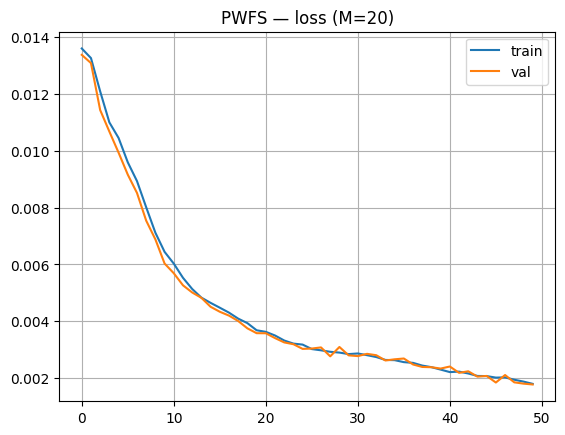

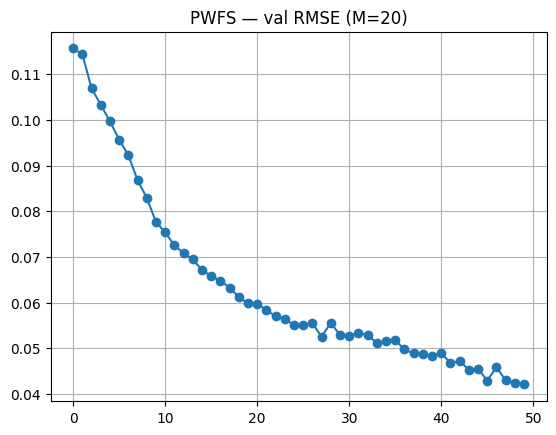

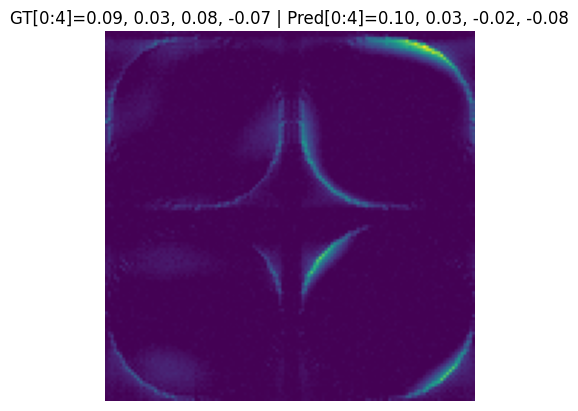

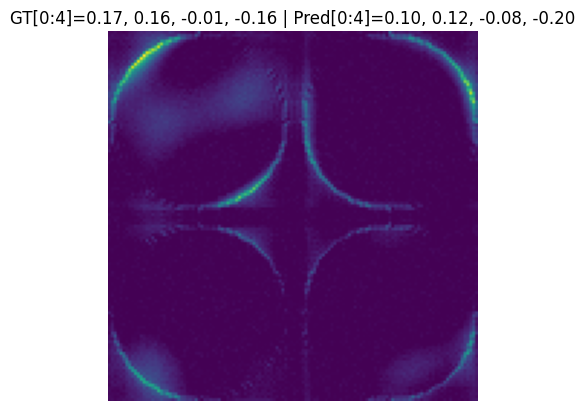

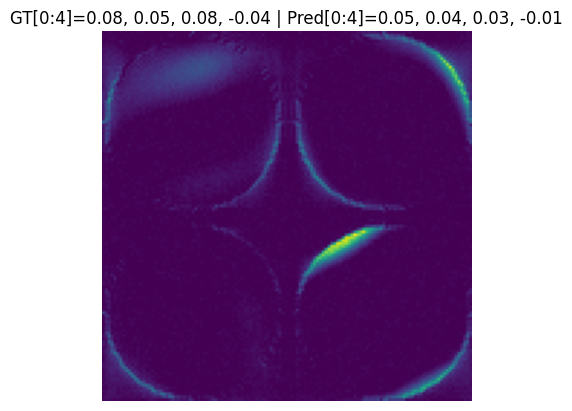

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random

def genOTF_PWFS4(N_fourier_points=128, N_points_aperture=64, separation=1.0, device='cpu'):
    """OTF/transferencia de un PWFS 4 caras no modulado (modelo simple en frecuencia)."""
    beta = separation * math.pi / (N_fourier_points / N_points_aperture)
    x = torch.arange(N_fourier_points, device=device, dtype=torch.float32)
    center = N_fourier_points // 2
    fx = (x - center) * (2.0 * center / N_fourier_points)
    FX, FY = torch.meshgrid(fx, fx, indexing='ij')
    H = lambda t: torch.heaviside(t, torch.tensor(0.5, device=device))
    pym = torch.zeros_like(FX, dtype=torch.complex64)
    for sx, sy in ((1,1),(1,-1),(-1,-1),(-1,1)):
        mask  = H(sx*FX) * H(sy*FY)
        phase = -beta * (sx*FX + sy*FY)
        pym   = pym + mask * torch.exp(1j * phase)
    return torch.fft.fftshift(pym).unsqueeze(0).unsqueeze(0)

def pwfs_forward(pupil_amp, pupil_phase, pyr_mask):
    """Propagación PWFS simple: Pupil -> Foco -> Prisma -> Detector (intensidad)."""
    u_pupil = pupil_amp * torch.exp(1j * pupil_phase)
    U_foc   = torch.fft.fft2(u_pupil)
    U_foc   = torch.fft.fftshift(U_foc, dim=(-2,-1))
    H_pyr   = pyr_mask[0,0]
    U_pyr   = U_foc * H_pyr
    U_pyr   = torch.fft.ifftshift(U_pyr, dim=(-2,-1))
    u_det   = torch.fft.ifft2(U_pyr)
    I_det   = u_det.real**2 + u_det.imag**2
    return I_det

def make_circular_pupil(N, D, device):
    y = torch.arange(N, device=device) - N//2
    x = torch.arange(N, device=device) - N//2
    Y, X = torch.meshgrid(y, x, indexing='ij')
    R = torch.sqrt(X**2 + Y**2)
    return (R <= (D/2)).float()

def add_noise(x, rn=2.0, photons=1e4, scale=1.0, use_poisson=True):
    y = x.real.float().clamp(min=0)*scale
    if use_poisson: y = torch.poisson((y*photons).clamp(min=0))/photons
    return (y + torch.randn_like(y)*rn).clamp_(min=0)

def noll_to_nm(j):
    # Referencia estándar: Noll 1976
    n = 0
    j1 = j - 1
    while j1 >= n + 1:
        n += 1
        j1 -= n
    m = (-n + 2*j1)
    return n, m

def zernike_radial(n, m, r):
    m = abs(m)
    R = torch.zeros_like(r)
    for k in range((n - m)//2 + 1):
        c = ((-1)**k) * math.comb(n - k, k) * math.comb(n - 2*k, (n - m)//2 - k)
        R = R + c * r**(n - 2*k)
    return R

def zernike(n, m, rho, theta):
    R = zernike_radial(n, m, rho)
    if m > 0:
        Z = R * torch.cos(m * theta)
    elif m < 0:
        Z = R * torch.sin(-m * theta)
    else:
        Z = R
    return Z

def build_zernike_stack(N, D, device, num_modes, exclude_piston=True):
    yy = torch.arange(N, device=device) - N//2
    xx = torch.arange(N, device=device) - N//2
    Y, X = torch.meshgrid(yy, xx, indexing='ij')
    r = torch.sqrt(X**2 + Y**2) / (D/2)          # radio normalizado al disco unidad
    th = torch.atan2(Y, X)
    pupil = (r <= 1.0).float()

    # Elegimos índices de Noll empezando en j=1, pero quizá saltamos j=1 (pistón)
    modes = []
    j = 1
    while len(modes) < (num_modes + (1 if exclude_piston else 0)):
        n, m = noll_to_nm(j)
        modes.append((j, n, m))
        j += 1

    if exclude_piston:
        modes = [t for t in modes if t[0] != 1]

    modes = modes[:num_modes]

    Zs = []
    for j, n, m in modes:
        Z = zernike(n, m, torch.clamp(r, 0, 1), th) * pupil
        # Normaliza a var ~1 dentro de pupila para que las amplitudes sean comparables
        Z_in = Z[pupil.bool()]
        std = Z_in.std() if Z_in.numel() > 0 else torch.tensor(1.0, device=device)
        Zs.append(Z / (std + 1e-8))
    Z_stack = torch.stack(Zs, dim=0)   # [M, N, N]
    return Z_stack, pupil, modes
class TinyPWFSNet(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, out_dim)
        )
    def forward(self, x): 
        return self.head(self.backbone(x))

class PWFS_Zernike_Dataset(Dataset):
    def __init__(self,
                 n=2000,
                 img_size=128,
                 pupil_diam=64,
                 separation=1.0,
                 num_modes=10,
                 coeff_scale=0.2,
                 device='cpu',
                 seed=0,
                 exclude_piston=True):
        self.n = n
        self.N = img_size
        self.D = pupil_diam
        self.device = torch.device(device)
        self.num_modes = num_modes
        self.coeff_scale = coeff_scale
        random.seed(seed); torch.manual_seed(seed)

        self.otf_pyr = genOTF_PWFS4(self.N, self.D, separation, device=self.device)
        self.Z_stack, self.pupil, self.modes = build_zernike_stack(
            self.N, self.D, self.device, num_modes=num_modes, exclude_piston=exclude_piston
        )

    def __len__(self): return self.n

    def __getitem__(self, idx):
        c = (torch.rand(self.num_modes, device=self.device)*2 - 1) * self.coeff_scale  # [M]
        phi = (c.view(-1,1,1) * self.Z_stack).sum(dim=0)   # [N,N]
        I   = pwfs_forward(self.pupil, phi, self.otf_pyr)
        m, s = I.mean(), I.std()
        I = (I - m) / (s + 1e-6)
        x = I.unsqueeze(0).float().cpu()          # [1,N,N]
        y = c.float().cpu()                       # [M]
        return x, y
    
def rmse(a,b): 
    return torch.sqrt(((a-b)**2).mean())

@torch.no_grad()
def eval_epoch(model, loader, device, loss_fn):
    model.eval(); total=0.0; total_rmse=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        x = add_noise(x, rn=0.2, photons=10e3, scale=2.0, use_poisson=True)
        pred = model(x)
        loss = loss_fn(pred, y)
        total += loss.item() * y.size(0)
        total_rmse += rmse(pred, y).item() * y.size(0)
    n = len(loader.dataset)
    return total/n, total_rmse/n

def train_epoch(model, loader, device, opt, loss_fn):
    model.train(); total=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        x = add_noise(x, rn=0.2, photons=10e3, scale=2.0, use_poisson=True)
        pred = model(x)
        loss = loss_fn(pred, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        total += loss.item() * y.size(0)
    return total / len(loader.dataset)   

device = 'cuda:7' if torch.cuda.is_available() else 'cpu'

NUM_MODES    = 20 #Maximun
COEFF_SCALE  = 0.20      
IMG          = 128
PUPIL_PIX    = 60
BATCH_TR     = 32
BATCH_VAL    = 64
EPOCHS       = 50
LR           = 1e-3 

train_ds = PWFS_Zernike_Dataset(n=4000, img_size=IMG, pupil_diam=PUPIL_PIX,
                                separation=1.1, num_modes=NUM_MODES,
                                coeff_scale=COEFF_SCALE, device=device, seed=0)

val_ds   = PWFS_Zernike_Dataset(n=800,  img_size=IMG, pupil_diam=PUPIL_PIX,
                                separation=1.1, num_modes=NUM_MODES,
                                coeff_scale=COEFF_SCALE, device=device, seed=1)

train_dl = DataLoader(train_ds, batch_size=BATCH_TR, shuffle=True, num_workers=0)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_VAL, shuffle=False, num_workers=0)

model = TinyPWFSNet(out_dim=NUM_MODES).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
loss_fn = nn.MSELoss()

train_curve, val_curve, val_rmse = [], [], []

for ep in range(1, EPOCHS + 1):
    tr = train_epoch(model, train_dl, device, opt, loss_fn)
    va, va_r = eval_epoch(model, val_dl, device, loss_fn)
    train_curve.append(tr); val_curve.append(va); val_rmse.append(va_r)
    if ep % 5 == 0 or ep == 1:
        print(f'Epoch {ep:02d} | train={tr:.4f} | val={va:.4f} | val RMSE={va_r:.4f}')

plt.figure(); plt.plot(train_curve, label='train'); plt.plot(val_curve, label='val')
plt.legend(); plt.title(f'PWFS — loss (M={NUM_MODES})'); plt.grid(True); plt.show()

plt.figure(); plt.plot(val_rmse, marker='o')
plt.title(f'PWFS — val RMSE (M={NUM_MODES})'); plt.grid(True); plt.show()


@torch.no_grad()
def show_preds(model, loader, k=3):
    model.eval(); shown=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        x = add_noise(x, rn=0.2, photons=10e3, scale=2.0, use_poisson=True)
        p = model(x)
        for i in range(min(k-shown, x.size(0))):
            img = x[i,0].cpu().numpy()
            plt.figure(); plt.imshow(img, cmap='viridis'); plt.axis('off')
            Mshow = min(4, y.shape[-1])
            gt_str = ", ".join([f"{y[i,j].item():.2f}" for j in range(Mshow)])
            pr_str = ", ".join([f"{p[i,j].item():.2f}" for j in range(Mshow)])
            plt.title(f'GT[0:{Mshow}]={gt_str} | Pred[0:{Mshow}]={pr_str}')
            plt.show()
        shown += min(k-shown, x.size(0))
        if shown >= k: break

show_preds(model, val_dl, k=3)


In [ ]:
#!pip install onnx
import torch, json, os, time


ckpt = {
    "state_dict": model.state_dict(),
    "epoch": EPOCHS,
    "optimizer": opt.state_dict(),
    "meta": {
        "IMG": IMG,
        "PUPIL_PIX": PUPIL_PIX,
        "NUM_MODES": NUM_MODES,
        "COEFF_SCALE": COEFF_SCALE,
        "date": time.strftime("%Y-%m-%d %H:%M:%S"),
    }
}
os.makedirs("checkpoints", exist_ok=True)
torch.save(ckpt, "checkpoints/pwfs_zernike_last.pt")

import torch
import os

model_cpu = model.to("cpu").eval()

dummy = torch.randn(1, 1, IMG, IMG, dtype=torch.float32)  # [B, C=1, H, W]

os.makedirs("onnx", exist_ok=True)
onnx_path = f"onnx/pwfs_zernike_M{NUM_MODES}_IMG{IMG}.onnx"

torch.onnx.export(
    model_cpu,                          
    dummy,                              
    onnx_path,                          
    export_params=True,                 
    opset_version=17,                   
    input_names=["pwfs"],
    output_names=["zernike"],
)

print(f"[OK] Exportado a: {onnx_path}")


[OK] Exportado a: onnx/pwfs_zernike_M20_IMG128.onnx


/tmp/ipykernel_21294/215062945.py:28: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


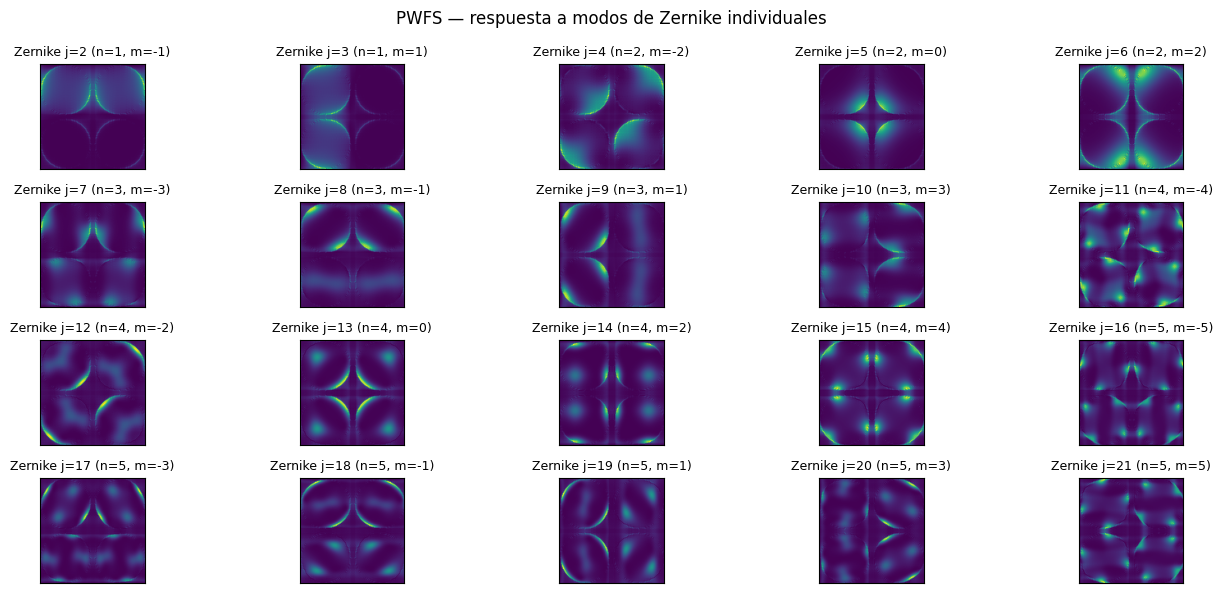

In [4]:
# ==== Propagar los primeros 10 modos de Zernike por el PWFS ====
@torch.no_grad()
def propagate_first_k_modes(
    N=128, D=60, separation=1.1, k=10, amp=0.20, device='cpu', exclude_piston=True
):
    """
    Devuelve un tensor [k, N, N] con las intensidades en detector para cada modo individual.
    Cada modo se propaga con coeficiente 'amp' (los demás a 0).
    """
    dev = torch.device(device)
    # OTF de la pirámide
    H_pyr = genOTF_PWFS4(N_fourier_points=N, N_points_aperture=D,
                         separation=separation, device=dev)
    # Pila de modos (Z_stack: [k, N, N]), pupil: [N, N], modes: lista de (j, n, m)
    Z_stack, pupil, modes = build_zernike_stack(
        N, D, dev, num_modes=k, exclude_piston=exclude_piston
    )

    # Propagar cada modo de forma aislada
    outs = []
    for i in range(k):
        # fase = amp * Zi dentro de la pupila
        phi = (amp * Z_stack[i]).to(dev)
        I = pwfs_forward(pupil.to(dev), phi, H_pyr.to(dev))  # [N, N]
        # Normalización simple para visualizar (z-score)
        m, s = I.mean(), I.std()
        I = (I - m) / (s + 1e-6)
        outs.append(I.float().cpu())

    I_stack = torch.stack(outs, dim=0)  # [k, N, N]
    return I_stack, modes, pupil.cpu()

# Ejecutar y visualizar
k = 20  # primeros 10 (sin pistón)
I_stack, modes, pupil = propagate_first_k_modes(
    N=IMG, D=PUPIL_PIX, separation=1.1, k=k, amp=1.0, device=device, exclude_piston=True
)

# Mostrar en una grilla 2x5
import matplotlib.pyplot as plt
rows, cols = 4, 5
plt.figure(figsize=(14, 6))
for i in range(k):
    j, n, m = modes[i]  # (Noll j, n, m)
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(I_stack[i].numpy(), cmap='viridis')
    ax.set_title(f'Zernike j={j} (n={n}, m={m})', fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])
plt.suptitle('PWFS — respuesta a modos de Zernike individuales', fontsize=12)
plt.tight_layout()
plt.show()
